In [65]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from netcal.metrics import ECE, ACE

import pickle
import random

from utils_notebook import f_probs_ovr_poe_logits_weighted, modal_probs_decreasing, modal_probs_average, modal_probs_decreasing_count, modal_probs_decreasing_relative

In [2]:
MODEL = 'DVT_Deit_small'

In [3]:
with open(f'output/{MODEL}.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
logits, targets, anytime_classification = data
targets = targets.cpu()

In [72]:
anytime_classification

[72.666, 78.99, 81.804]

In [5]:
# type(logits), logits.shape, type(targets), targets.shape, type(anytime_classification), len(anytime_classification)

## 1 Anytime Performance

In [6]:
L = len(logits)
N = logits.shape[1]

In [7]:
L, N

(3, 50000)

In [8]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [73]:
acc

[tensor(0.7267), tensor(0.7899), tensor(0.8180)]

In [9]:
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted(logits))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

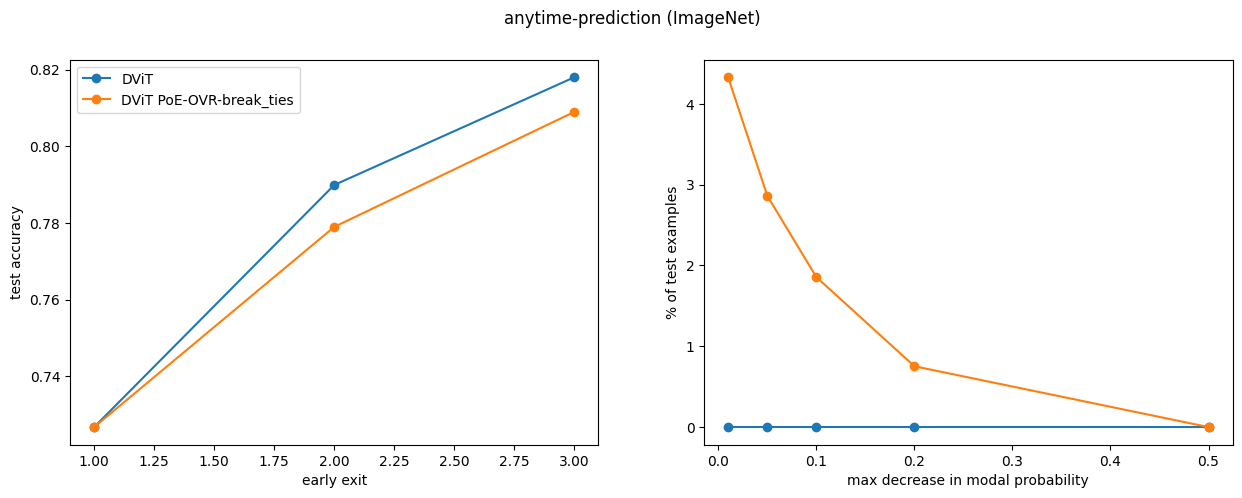

In [10]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
# ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()

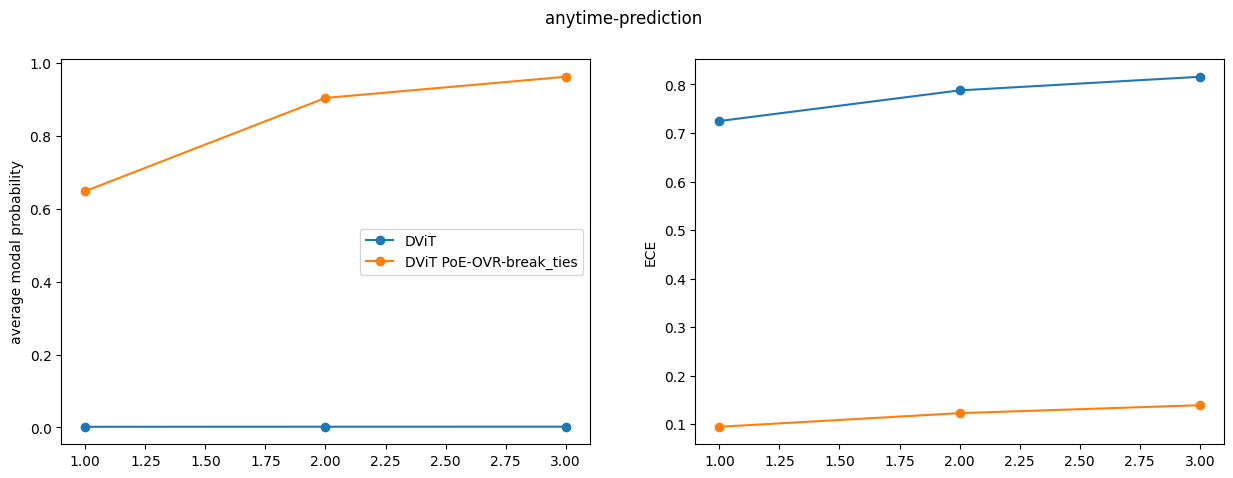

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
early_exits = [i + 1 for i in range(len(acc))]
for _preds, _probs, label in [
                            (preds, probs, 'DViT'), 
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'DViT PoE-OVR-break_ties'),
                            ]:
    modal_probs = modal_probs_average(_preds, _probs, L)
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, modal_probs.numpy(), marker='o', label=label)
    ax[1].plot(early_exits, ece, marker='o', label=label)
ax[0].legend()
ax[0].set_ylabel('average modal probability')
ax[1].set_ylabel('ECE')


plt.suptitle('anytime-prediction')
plt.show()

In [17]:
l, i = 2, 100
probs[l, i, :].shape, probs[l, i, :].sum(), probs[l, i, :].max()

(torch.Size([1000]), tensor(1.), tensor(0.0023))

[49422, 25224, 39275, 45060, 32380, 12721, 27341, 10900, 17498, 31289]


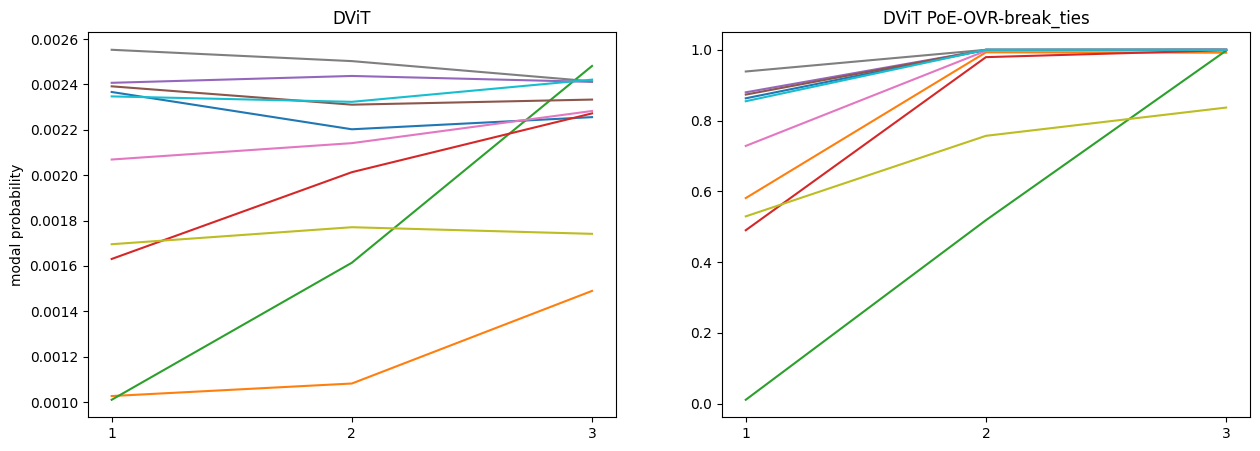

[44804, 12126, 13606, 13235, 15471, 47441, 40462, 35391, 32442, 28971]


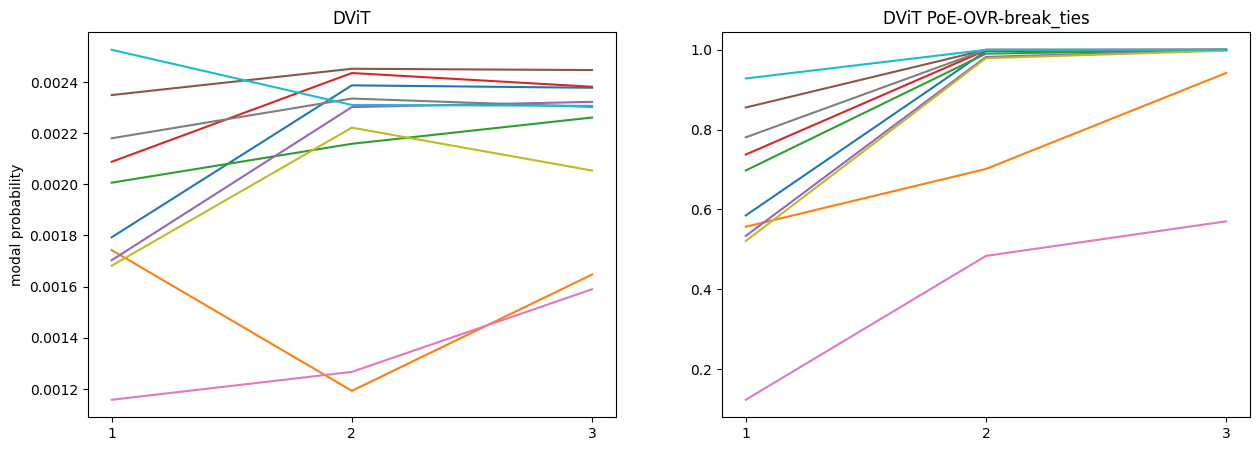

[36228, 20989, 37856, 19767, 34472, 30381, 39229, 22186, 1905, 46612]


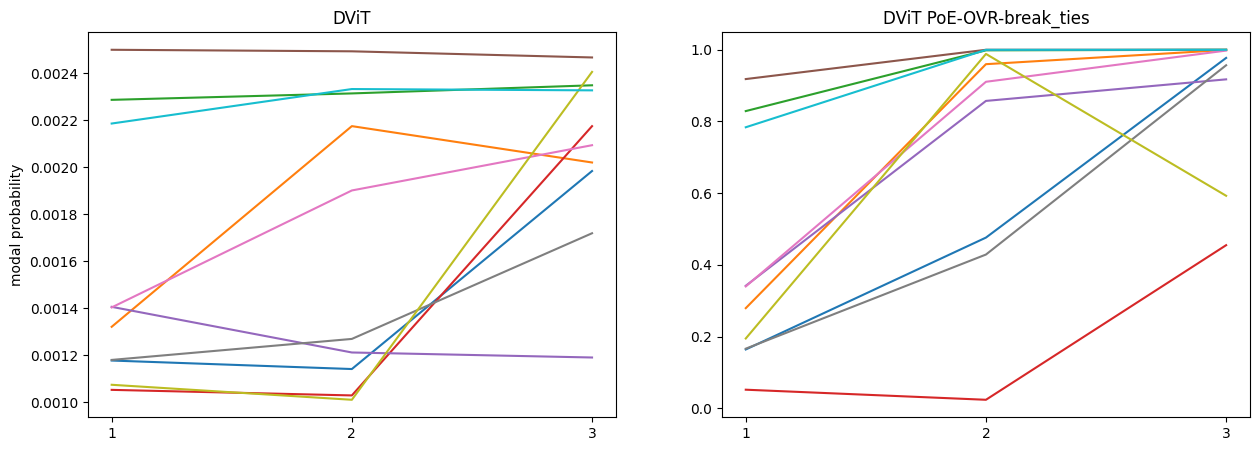

[34956, 11877, 18492, 14757, 40077, 39470, 41763, 20199, 13777, 12884]


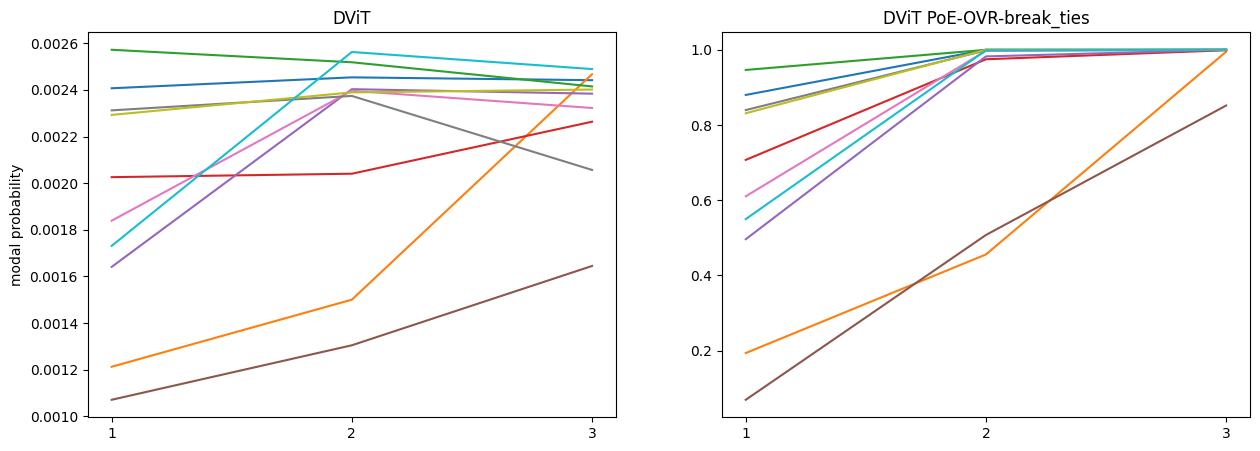

[44146, 35413, 25391, 10583, 16673, 33698, 27353, 12798, 39461, 46378]


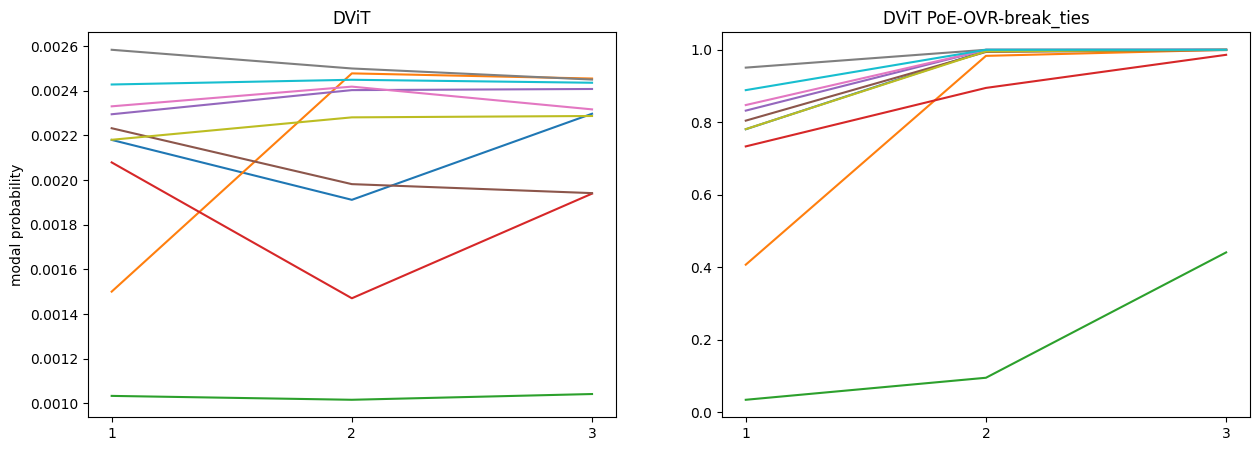

In [74]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    samples = random.sample(range(N), 10)
    print(samples)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[0].set_xticks(range(1, len(probs_i_baseline) + 1))
        ax[1].set_xticks(range(1, len(probs_i_baseline) + 1))
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('DViT')
    ax[1].set_title('DViT PoE-OVR-break_ties')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [76]:
i = 44146
probs_poe_ovr_break_ties[:, i, preds_poe_ovr_break_ties[L - 1][i]]

tensor([0.7806, 0.9976, 1.0000])

In [80]:
(probs_poe_ovr_break_ties[L - 1, i, :] > 0).sum(), probs_poe_ovr_break_ties[L - 1, i, :].max()

(tensor(1000), tensor(1.0000))

In [40]:
print('% of test examples with decreasing modal probability trajectory')
print(f'DViT: {(modal_probs_decreasing_count(preds, probs, layer=L, N=N) / N) * 100:.2f} %') 
print(f'DViT PoE-OVR-break_ties: {(modal_probs_decreasing_count(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N) / N) * 100:.2f} %') 

% of test examples with decreasing modal probability trajectory
DViT: 59.69 %
DViT PoE-OVR-break_ties: 5.00 %


In [32]:
THRES = [0.01, 0.05, 0.1, 0.2, 0.3]

decrease_rel_probs = modal_probs_decreasing_relative(preds, probs, layer=L, N=N)
decrease_rel_probs_poe_ovr_break_ties = modal_probs_decreasing_relative(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, layer=L, N=N)

decreases_rel_probs, decreases_rel_probs_poe_ovr_break_ties = [], []
for thres in THRES:
    decreases_rel_probs.append(sum([1 for i in decrease_rel_probs if i < -thres]) / len(decrease_rel_probs))
    decreases_rel_probs_poe_ovr_break_ties.append(sum([1 for i in decrease_rel_probs_poe_ovr_break_ties if i < -thres]) / len(decrease_rel_probs_poe_ovr_break_ties))

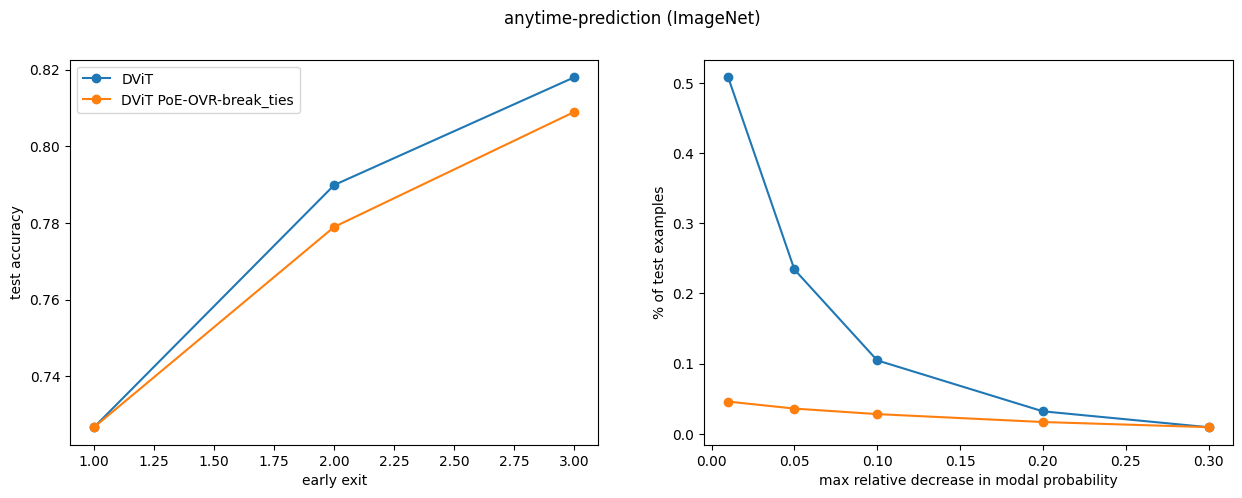

In [34]:
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(early_exits, acc, label='DViT', marker='o',)
ax[0].plot(early_exits, acc_poe_ovr_break_ties, label='DViT PoE-OVR-break_ties', marker='o')
ax[0].legend()
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')


ax[1].plot(THRES, decreases_rel_probs, marker='o', label='DViT')
ax[1].plot(THRES, decreases_rel_probs_poe_ovr_break_ties, marker='o', label='DViT PoE-OVR-break_ties')
ax[1].set_xlabel('max relative decrease in modal probability')
ax[1].set_ylabel('% of test examples')

plt.suptitle(f'anytime-prediction (ImageNet)')
plt.show()

In [69]:
thres_dict = {}
for thres in [0., 0.0001, 0.0005, 0.001]:
    _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits, threshold=thres))
    _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
    _acc = [(targets == _preds[i]).sum() / len(targets) for i in range(L)]
    _modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)

    groud_truth_coverage = {l: 0 for l in range(L)}
    predictive_set_size = {l: [] for l in range(L)}
    for l in range(L):
        for n in range(N):
            if _probs[l, n, targets[n]] > 0.:
                groud_truth_coverage[l] += 1
            predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

    predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
    predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
    groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
    thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs)

/home/metod/Desktop/PhD/year1/PoE/Dynamic-Vision-Transformer/utils_notebook.py:54: RuntimeWarning: invalid value encountered in true_divide
  probs = (probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2))


In [70]:
for thres, (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs) in thres_dict.items():
    print(f'thres: {thres}')
    print(f'ground truth coverage: {groud_truth_coverage_pct}')
    print(f'predictive set size: {predictive_set_size_mean}')
    print(f'accuracy: {_acc}')
    print(f'modal probs: {_modal_probs}')
    print('==========================================')

thres: 0.0
ground truth coverage: {0: 1.0, 1: 1.0, 2: 1.0}
predictive set size: {0: 1000.0, 1: 1000.0, 2: 1000.0}
accuracy: [tensor(0.7267), tensor(0.7790), tensor(0.8090)]
modal probs: {0.01: 4.328, 0.05: 2.86, 0.1: 1.856, 0.2: 0.754, 0.5: 0.002}
thres: 0.0001
ground truth coverage: {0: 0.99914, 1: 0.99854, 2: 0.9981}
predictive set size: {0: 530.66146, 1: 353.9148, 2: 266.7413}
accuracy: [tensor(0.7267), tensor(0.7790), tensor(0.8090)]
modal probs: {0.01: 4.42, 0.05: 2.9139999999999997, 0.1: 1.886, 0.2: 0.762, 0.5: 0.004}
thres: 0.0005
ground truth coverage: {0: 0.99246, 1: 0.99, 2: 0.98748}
predictive set size: {0: 58.17582, 1: 21.3382, 2: 12.19156}
accuracy: [tensor(0.7267), tensor(0.7790), tensor(0.8090)]
modal probs: {0.01: 4.936, 0.05: 3.256, 0.1: 2.048, 0.2: 0.8099999999999999, 0.5: 0.008}
thres: 0.001
ground truth coverage: {0: 0.98598, 1: 0.9817, 2: 0.97798}
predictive set size: {0: 25.89028, 1: 10.91328, 2: 6.46758}
accuracy: [tensor(0.7267), tensor(0.7790), tensor(0.8089)]


all logits are positive...

In [66]:
pd.DataFrame(logits.numpy().reshape(-1)).describe()

,0
count,1.500000e+08
mean,9.999998e-04
std,2.349033e-02
min,2.540351e-08
25%,6.688498e-05
50%,1.085296e-04
75%,1.734271e-04
max,9.986227e-01


In [52]:
(logits > 0).sum()

tensor(150000000)

In [56]:
logits.shape[0] * logits.shape[1] * logits.shape[2]

150000000